<a href="https://colab.research.google.com/github/JoaoGranja/AnalyzeMovieReviews/blob/master/Great_Barrier_Reef_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Colab Preparation**

Beforing handling the project, we need to install Kaggle package to connect with kaggle platform and download the project dataset. I also share my google drive to simplify the connection with my kaggle account.

In [ ]:
#Package Installation and share Google Drive
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!pip install tensorflow_addons
!pip install --quiet vit-keras
!pip install -qU wandb

from google.colab import drive
drive.mount('/content/drive')

import os
First_Time = False
if not os.path.isdir('/root/.kaggle'):
  !mkdir /root/.kaggle
  !cp drive/MyDrive/colab/kaggle.json /root/.kaggle/kaggle.json
  !chmod 600 /root/.kaggle/kaggle.json
  First_Time = True
  print("First Time")

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
  Using cached kaggle-1.5.6-py3-none-any.whl
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#! kaggle competitions list

In [ ]:
## Download the competition dataset
if First_Time:
  !kaggle competitions download -c 'tensorflow-great-barrier-reef'

# **Great Barrier Reef Dataset**

Once downloaded the kaggle dataset 'tensorflow-great-barrier-reef', we need to unzip all files to be ready using them. Analyzing the files, we can note that there is a folder with training imagesa and a train.csv and test.csv file. Sample submission files are also provided to better understand its data formating.

In [ ]:
## Unzip the dataset files
if First_Time:
  !unzip /content/tensorflow-great-barrier-reef.zip &> /dev/null
  %rm -r *.zip

 # **Configuration and imports**

With the dataset ready, we start importing all modules we need for this project. I also use some configuration parameters to be used through the project

In [ ]:
# Imports libraries
import time
import gc
import sys, logging
import random, pickle
import warnings
from google.colab import files

sys.path.append('/content/drive/MyDrive/colab/Great_Barrier_Reef')

from itertools import groupby
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import matplotlib.pyplot as plt
import ast
from glob import glob
import matplotlib.image as mpimg

from joblib import Parallel, delayed

from IPython.display import display, HTML
import cv2 

# tensorflow and keras for CNN model
import tensorflow as tf
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Model, save_model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
#from keras.utils import multi_gpu_model
from tensorflow.keras.preprocessing.image import Iterator, load_img, img_to_array, ImageDataGenerator


import gbr_utils

# -------------------------------------- Configuration variables ----------------------
FOLD=20
NR_CLASSES = 1
IMAGE_SIZE=(720,1280)

#------------------------------  Set some configuration parameters -----------------------------------#
args = {}
args['seed'] = 42
args['data_augmentation'] = False
args['training'] = True
args['fine_tuning'] = False
args['evaluation_networks'] = True

#training arguments
args['batch_size'] = 16
args['train_epochs'] = 4
args['fine_tune_epochs'] = 5

#model arguments
args['compare_networks'] = ['vgg19', 'resnet50', 'efficientnetb0', 'efficientnetv2', 'vit-b32', 'vit_scratch']
args['network'] = 'vgg16'
args['models_dir'] = 'nn_models_checkpoints'

#optimizer arguments
args['optimizer'] = 'adam'
#args['weights'] = 'nn_models_checkpoints/best_{}.h5'.format(args['networks'][0])
args['learning_rate'] = 0.003
args['decay'] = 0.0001
args['loss'] = 'binary_crossentropy'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# **Pre-processing the training dataset**

In [ ]:
if "df" not in globals():
  ## Pre-process train.csv 
  df = pd.read_csv(f'train.csv')
  df = df.progress_apply(gbr_utils.get_path, axis=1)
  df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))

  ## Calculate Number of BBoxes
  df['num_bbox'] = df['annotations'].progress_apply(lambda x: 1 if len(x)>0 else 0)
  df['num_bbox'] = df['num_bbox'].astype(str)
  df['image_path'] = df['old_image_path'].astype(str)

  data = (df.num_bbox=="1").value_counts(normalize=True)*100
  print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


,video_id,sequence,video_frame,sequence_frame,image_id,annotations,old_image_path,image_path,label_path,num_bbox
0,0,40258,0,0,0-0,[],train_images/video_0/0.jpg,train_images/video_0/0.jpg,labels/video_0_0.txt,0
1,0,40258,1,1,0-1,[],train_images/video_0/1.jpg,train_images/video_0/1.jpg,labels/video_0_1.txt,0


In [ ]:
## Create Folds
from sklearn.model_selection import GroupKFold

kf = GroupKFold(n_splits = 20)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df, y = df.num_bbox, groups=df.sequence)):
    df.loc[val_idx, 'fold'] = fold
display(df.fold.value_counts())

0     2988
1     2959
2     2843
3     2800
4     1525
5     1423
6     1248
7     1167
8     1077
9      923
10     853
11     798
12     770
13     617
14     537
15     480
16     184
17     151
18      87
19      71
Name: fold, dtype: int64

In [ ]:
# Dataset
train_files = []
val_files   = []
train_df = df.query("fold==2")
valid_df = df.query("fold==4")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

(2843, 1525)

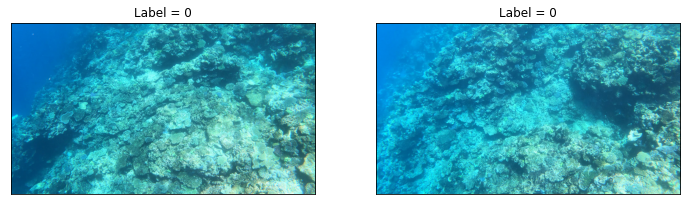

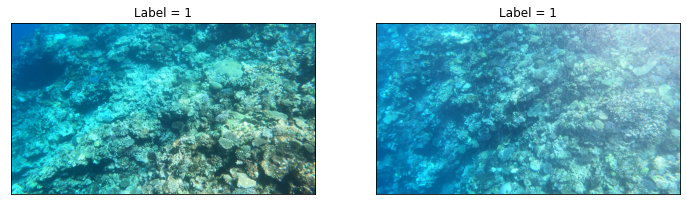

In [ ]:
#------------------------------ Plot random images and respective labels -----------------------------------#
from glob import glob
import matplotlib.image as mpimg

## Read Images without boundary box
n_images = 2
image_paths = train_df.query("num_bbox=='0'").sample(n = n_images).image_path

fig, axs = plt.subplots(1, n_images, figsize=(12, 12))

# View the images
for i, image_path in enumerate(image_paths):
    example = mpimg.imread(image_path)
    axs[i].imshow(example)
    axs[i].set_title("Label = 0", loc='center') 
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)

plt.show() 
plt.close()

## Read Images with boundary box
n_images = 2
image_paths = train_df.query("num_bbox=='1'").sample(n = n_images).image_path

fig, axs = plt.subplots(1, n_images, figsize=(12, 12)) 

# View the images
for i, image_path in enumerate(image_paths):
    example = mpimg.imread(image_path)
    axs[i].imshow(example)
    axs[i].set_title("Label = 1", loc='center') 
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    
plt.show() 
plt.close()

In [ ]:
#------------------------------ Random data augmentation -----------------------------------#
if args['data_augmentation']:
    train_datagen = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
else:
    train_datagen = ImageDataGenerator()

# prepare train generator
train_generator = train_datagen.flow_from_dataframe(
                                                  dataframe=train_df,
                                                  directory='',
                                                  x_col="image_path",
                                                  y_col="num_bbox",
                                                  batch_size=args['batch_size'],
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="binary",
                                                  target_size=IMAGE_SIZE)


test_datagen = ImageDataGenerator()
# prepare valid generator
test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe=valid_df,
                                                  directory='',
                                                  x_col="image_path",
                                                  y_col="num_bbox",
                                                  batch_size=args['batch_size'],
                                                  seed=42,
                                                  class_mode="binary",
                                                  shuffle=False,
                                                  target_size=IMAGE_SIZE)


Found 2843 validated image filenames belonging to 2 classes.
Found 1525 validated image filenames belonging to 2 classes.


<class 'numpy.ndarray'> (720, 1280, 3)
<class 'numpy.ndarray'> (720, 1280, 3)


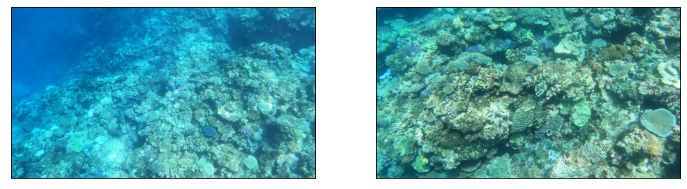

In [ ]:
n_images = 2
fig, axs = plt.subplots(1, n_images, figsize=(12, 12)) 

batch_sample = next(train_generator)[0]

# View the images
for i in range(n_images):
  example = batch_sample[i].astype('uint8')
  print(type(example), example.shape)

  axs[i].imshow(example)
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
    
plt.show() 
plt.close()

In [ ]:
#------------------------------ Define an optimizer -----------------------------------#
if 'optimizer' in args:
    if args['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']))
    elif args['optimizer'] == 'amsgrad':
        optimizer = Adam(learning_rate=args['learning_rate'], decay=float(args['decay']), amsgrad=True)
    elif args['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=args['learning_rate'], momentum=0.9, nesterov=True, decay=float(args['decay']))
else:
    optimizer = RMSprop(learning_rate=args['learning_rate'])

In [ ]:
from models.model_factory import make_model
import tensorflow_hub as hub
from models.models import *

args['network'] = 'efficientnetb0'
#------------------------------ Make the model -----------------------------------#
model = make_model(args['network'], (720,1280,3), NR_CLASSES)

if 'weights' not in args:
    print('No weights passed, training from scratch')
else:
    print('Loading weights from {}'.format(args['weights']))
    model.load_weights(args['weights'], by_name=True)

#------------------------------ Compile the model -----------------------------------#
model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 
model.summary()

No weights passed, training from scratch
Model: "efficientnetb0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 720, 1280, 3)]    0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Den

In [ ]:
#------------------------------ Model check points -----------------------------------#
best_model_file = '{}/best_{}.h5'.format(args['models_dir'], model.name)
last_model_file = '{}/last_{}.h5'.format(args['models_dir'], model.name)
model_file = '{}/model_{}.h5'.format(args['models_dir'], model.name)
history_name = '{}/history_{}.h5'.format(args['models_dir'], model.name)
#------------------------------ Callbacks -----------------------------------#

#ModelCheckpoint(filepath=last_model_file, monitor='val_loss', verbose=1, mode='min',
#            save_freq='epoch', save_best_only=False, save_weights_only=False)

callbacks = [
        # Callback to reduce the learning rate once the plateau has been reached:
        ReduceLROnPlateau(
            monitor='val_loss',
            min_delta=0.1,
            factor=1/3,
            patience=3,
            mode='auto',
            verbose=1,
            cooldown=0,
            min_lr=1e-8
        ),
        # Callback to stop the training once no more improvements are recorded:
        EarlyStopping(
            min_delta=0.001,
            verbose=1,
            patience=10,
            mode='auto',
            restore_best_weights=True
        ),
        # Callback to log the graph, losses and metrics into TensorBoard:
        #TensorBoard(log_dir="logs/{}".format(model.name)
        #),
        # Callback to save the best model specifying the epoch and val-loss in the filename:
        ModelCheckpoint(filepath=best_model_file, 
            monitor='val_loss',
            verbose=1,
            mode='min',
            save_freq='epoch',
            save_best_only=True,
            save_weights_only=False)
    ]
if args['training']:
    print("Training model {}".format(model.name))
    #------------------------------ Model Fit -----------------------------------#
    history = model.fit(
                        train_generator,
                        steps_per_epoch=len(train_df.image_path)//train_generator.batch_size,
                        epochs=args['train_epochs'],
                        validation_data=test_generator,
                        validation_steps=len(valid_df.image_path)//test_generator.batch_size,
                        callbacks=callbacks)

    #------------------------------ Save the last model weights -----------------------------------#
    model.save(model_file)
    print("Saved model to disk")
    with open(history_name, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

else:
  if args['network'] == 'efficientnetv2': 
    model = load_model(model_file, custom_objects={'KerasLayer':hub.KerasLayer})
  else:
    model = load_model(model_file)

  if os.path.isfile(history_name):
    with open(history_name, 'rb') as data:
          history = pickle.load(data)

Training model efficientnetb0
Epoch 1/4
177/177 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.3880
Epoch 00001: val_loss improved from inf to 0.15128, saving model to nn_models_checkpoints/best_efficientnetb0.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


177/177 [==============================] - 199s 1s/step - loss: 0.4015 - accuracy: 0.3880 - val_loss: 0.1513 - val_accuracy: 0.0191 - lr: 0.0030
Epoch 2/4
  7/177 [>.............................] - ETA: 1:36 - loss: 0.0983 - accuracy: 0.4107

In [ ]:
if args['fine_tuning']:
  base_model = model.get_layer(args['network'])
  base_model.trainable = True

  if (args['network']  in   ['vgg19', 'resnet50', 'efficientnetb0']):
    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = len(base_model.layers) // 2

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

  #------------------------------ Compile the model -----------------------------------#
  model.compile(loss=args['loss'], optimizer=RMSprop(learning_rate=args['learning_rate']/100), metrics=['accuracy']) 
  model.summary()

  #------------------------------ Model Fit -----------------------------------#
  total_epochs =  args['train_epochs'] + args['fine_tune_epochs']
  fine_tune_history = model.fit(
                      train_generator,
                      steps_per_epoch=len(train_df.image_path)//train_generator.batch_size,
                      epochs=total_epochs,
                      initial_epoch = args['train_epochs'],
                      validation_data=test_generator,
                      callbacks=callbacks)

  #------------------------------ Save the last model weights -----------------------------------#
  model.save(model_file)
  print("Saved model to disk")    

In [ ]:
#------------------------------ Plot diagnostic learning curves -----------------------------------#
def summarize_diagnostics(history, model_name, fine_tune_history={}):
    # plot loss
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    if args['fine_tuning']:
      acc += fine_tune_history['accuracy']
      val_acc += fine_tune_history['val_accuracy']

      loss += fine_tune_history['loss']
      val_loss += fine_tune_history['val_loss']  

    plt.figure(figsize=(8, 8))
    plt.subplot(2,1,1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.1, 1])
    if args['fine_tuning']:
      plt.plot([args['train_epochs'],args['train_epochs']],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    #plt.ylim([0, 10])
    if args['fine_tuning']:
      plt.plot([args['train_epochs'],args['train_epochs']],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    
    # save plot to file
    plt.savefig("results_" + model_name  + '_plot.png')
    plt.show()
    plt.close()

if args['evaluation_networks'] is False:
  if args['training']:  
    dict_history = history.history
  else:
    dict_history = history

  if args['fine_tuning']:
    summarize_diagnostics(dict_history, args['network'], fine_tune_history.history)
  else:
    summarize_diagnostics(dict_history, args['network'])

In [ ]:
gc.collect

if args['evaluation_networks']:

  def show_image_prediction(loaded_model, n_images):
    #Try out the model on an image from the test data:
    #plt.figure(figsize=(30, 30))
    fig, axs = plt.subplots(1, n_images, figsize=(15, 15))
    fig.tight_layout(pad=1.0)

    # View the images
    for i in range(n_images):
        index = random.randint(0, len(x_test))
        image = x_test[index].squeeze()
        true_index = [i for i in range(NR_CLASSES) if y_test[index][i] == 1 ][0]

        prediction_scores = loaded_model.predict(np.expand_dims(image, axis=0))
        predicted_index = np.argmax(prediction_scores)

        #image = np.add(image*128,128).astype(int)
        axs[i].imshow(image)
        axs[i].set_title("True Label = {0}, \n Predicted label = {1}".format(true_index, predicted_index))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    
    plt.show()
    plt.close()

  #------------------------------ Predict on some test images -----------------------------------#
  i=1

  for network in args['compare_networks']:
      print("----------------------- model {} -----------------------".format(network))


      #plt.subplot(1, len(args['networks']), i)
      #Load last model parameters
      model_file = '{}/model_{}.h5'.format(args['models_dir'], network)
      print(model_file)

      #Load the model
      if network == 'efficientnetv2': 
        loaded_model = load_model(model_file, custom_objects={'KerasLayer':hub.KerasLayer})
      else:
        loaded_model = load_model(model_file)
      print("Loaded model {} from disk".format(model_file))
      loaded_model.compile(loss=args['loss'], optimizer=optimizer, metrics=['accuracy']) 

      #Try out the model on an image from the test data:
      show_image_prediction(loaded_model,8)

      #------------------------------ Evaluate model on testing dataset -----------------------------------#
      #_, acc = loaded_model.evaluate(x_train, y_train, verbose=0)
      #print("Training accuracy of model {0} = {1}".format(loaded_model.name, acc))
      _, acc = loaded_model.evaluate(x_test, y_test, verbose=0)
      print("Testing accuracy of model {0} = {1}".format(loaded_model.name, acc)) 

      #------------------------------ Plot all model results -----------------------------------#
      # save plot to file
      filename = "results_" + network + '_plot.png'
      im = cv2.imread(filename)
      plt.imshow(im)
      plt.title("Accuray Results of model {}".format(network))
      i = i + 1

      plt.show()
  plt.close()